In [1]:
# 加载音频文件
from scipy.io import wavfile

def LoadWav(audio_file):
    sample_rate, signal = wavfile.read(audio_file)
    print('sample_rate:{}, len:{}'.format(sample_rate, len(signal)))
    return sample_rate, signal

In [2]:
import numpy as np

# 获取 MAN 文件
def GenerateManSeq(slotCnt, manFile, FRAME_RATE, BASE_RATE,\
        HIGH_VALUE):
    slotCnt = int(slotCnt)
    manSeq = [0] * slotCnt
    stotal = (FRAME_RATE / BASE_RATE) * slotCnt

    for line in open(manFile):
        sl = line.strip()
        if sl == "" or sl[0] == "#":
            continue
        minute, second = map(int, sl.split(':'))
        stime = minute * 60 + second

        # round to an even number
        pos = round(stime / stotal * slotCnt)

        if 0 <= pos and pos < slotCnt:
            manSeq[pos] = HIGH_VALUE
    return np.array(manSeq)

# 获取 MAN 文件
def GenerateManSeqSec(slotCnt, manFile, FRAME_RATE, BASE_RATE,\
        HIGH_VALUE):
    lis = []

    for line in open(manFile):
        sl = line.strip()
        if sl == "" or sl[0] == "#":
            continue
        minute, second = map(int, sl.split(':'))
        stime = minute * 60 + second
        lis.append(stime)

    return lis

In [3]:
# 生成编号数列

def GetPreSeq(manSeq, length):
    preSeq = manSeq.copy()
    for i in range(1, len(preSeq)):
        preSeq[i] ^= preSeq[i - 1]
        
    assert(abs(len(preSeq) - length) <= 5, "len(preSeq) =%d, length = %d" % (len(preSeq), length))
    return preSeq[:length]

<ipython-input-3-a1912e3b4ef1>:8: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(abs(len(preSeq) - length) <= 5, "len(preSeq) =%d, length = %d" % (len(preSeq), length))


In [4]:
import numpy as np
# np.set_printoptions(threshold=np.inf)

import pylab as pl
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from scipy.io import wavfile
# download opensouce audio in
# http://www.voiptroubleshooter.com/open_speech/american.html
def mfcc(sample_rate, signal):
    # 一、预处理(Preprocess)
    # 加载模型(load audio)
    print('sample_rate:{}, len:{}'.format(sample_rate, len(signal)))

    # signal = signal[: int(3.5 * sample_rate)]  # read first 3.5s data for example.

    # n_frames = len(signal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, signal)
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Original audio')
    # pl.show()

    # 预加重(Pre-Emphasis)
    # y(t) = x(t) - a * x(t - 1)
    pre_emphasis = 0.97  # usually 0.95 or 0.97
    emphasized_signal = np.append(
        signal[0],
        signal[1:] - pre_emphasis * signal[: -1]
    )

    # n_frames = len(emphasized_signal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, emphasized_signal)
    #
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Pre-Emphasis')
    # pl.show()

    # 分帧(Framing)
    # here, params set as follows:
    # frame_size = 0.025(s), it menas 8kHz signal has 0.025 * 8000 = 200 samples.
    # frame_stride = 0.01(s), 0.01 * 8000 = 80 samples.
    # overlap = 0.015(s), 0.015 * 8000 = 125 samples.
    frame_size, frame_stride, overlap = 0.025, 0.01, 0.015  # Convert from seconds to samples
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    singal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(
        float(np.abs(singal_length - frame_length)) / frame_step
    ))  # make sure we have at least 1 frame.

    pad_singal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_singal_length - singal_length))
    # pad singal to make sure that all frames have equal number of
    # samples without truncating any samples from the original signal.
    pad_singal = np.append(emphasized_signal, z)

    indices = np.tile(
        np.arange(0, frame_length), (num_frames, 1)
    ) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step),
        (frame_length, 1)
    ).T
    frames = pad_singal[indices.astype(np.int32, copy=False)]

    # 加窗(Window)
    # W(n, a) = (1 - a) - a * cos(2 * pi * n / (N - 1))
    # 0 <= n <= N, N is Window length, set a = 0.46 here.
    window = np.hamming(frame_length)
    # plt.plot(window)
    # plt.xlabel("Samples")
    # plt.ylabel("Amplitude")
    # plt.title("Hamming window")
    # plt.show()

    # n = np.arange(0, frame_length)
    # window = 0.54 - 0.46 * np.cos(2.0 * np.pi * n) / (frame_length - 1)  # Explicit Implementation
    frames *= window

    # n_frames = len(pad_singal)
    # time = np.arange(0, n_frames) * (1.0 / sample_rate)
    # pl.subplot(1, 1, 1)
    # pl.plot(time, pad_singal)
    #
    # pl.xlabel('time (seconds)')
    # pl.ylabel('amplitude')
    # pl.title('Framing')
    # pl.show()

    # 二、傅里叶变换(FFT)和功率谱(Power Spectrum)
    # do an N-pont FFT on each frame to calculate the frequency spectrum,
    # also called STFT(Short-time FT), where N is typically 256 or 512,
    NFFT = 512
    mag_frames = np.absolute((np.fft.rfft(frames, NFFT)))  # Magnitude of the FFT

    # compute the power spectrum using the following eqution:
    # P = |FFT(Xi)|^2 / N, Xi is ith frame of signal x.
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    # 三、滤波器组(Filter Banks)
    # The final step to computing filter banks is applying triangular filters,
    # typically 40 filters, nfilt = 40 on a Mel-scale to the power spectrum to extract frequency bands.
    # convert frequency(f) and Mel(m) with equations:
    # m = 2595 * log10(1 + f / 700)
    # f = 700 * (10 ^ (m / 2595) - 1)
    n_filters = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, n_filters + 2)  # need 40 filters banks, so need 42 points
    hz_points = (700 * (10 ** (mel_points / 2595) - 1))  # convert Mel to Hz
    # bin = sample_rate / NFFT  # fequency bin equation
    bins = np.floor((NFFT + 1) * hz_points / sample_rate)  # hz_points / bin

    fbank = np.zeros((n_filters, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, n_filters + 1):
        f_m_minus = int(bins[m - 1])
        f_m = int(bins[m])
        f_m_plus = int(bins[m + 1])

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bins[m - 1]) / (bins[m] - bins[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bins[m + 1] - k) / (bins[m + 1] - bins[m])

    # pl.plot(fbank.T)
    # pl.subplot(1, 1, 1)
    # pl.xlabel("Frequency")
    # pl.ylabel("time()")
    # pl.title("40 Filter Banks")
    # pl.show()

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)  # db

    # pl.plot(filter_banks)
    # pl.subplot(1, 1, 1)
    # pl.xlabel("Frequency")
    # pl.ylabel("Time")
    # pl.title("Spectrogram")
    # pl.show()

    # 四、梅尔频率倒谱系数(MFCCs)
    # apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients
    # and yield a compressed representation of the filter banks.
    num_ceps = 12
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 2: (num_ceps + 2)]  # keep 3-14

    # apply sinusoidal liftering to the MFCCs to de-emphasize higher MFCCs
    (n_frames, n_coeff) = mfcc.shape
    n = np.arange(n_coeff)
    cep_lifter = 22
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift
    
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    return mfcc

In [5]:
def GetSolveName(songid: str):
    assert len(songid) == 4
    return "./Data/SOLVE/%s.solve.json" % songid

In [6]:
class blank:
    def __init__(self):
        self.id = 0
        self.starttime = 0
        self.endtime = 0
        self.column = 0
        self.cut = 0

    def length(self):
        return self.endtime - self.starttime

    def print(self):
        print("id:%2d stime:%5d etime:%5d column:%d cut:%d" % (self.id, self.starttime, self.endtime, self.column, self.cut))

    def save(self, songid):
        BLANK_DATA_FILE = "./Data/JSON/BlankData.json"

        import json
        with open(BLANK_DATA_FILE) as fp:
            data = json.load(fp)

        data.append({
            'songid': songid,
            'id': self.id,
            'starttime': self.starttime,
            'endtime': self.endtime,
            'column': self.column,
            'cut': self.cut,
        })
        
        with open(BLANK_DATA_FILE, "w") as fp:
            json.dump(data, fp, indent=4)
    
    def saveToSolve(self, songid):
        SOLVE_FILE_NAME = GetSolveName(songid)

        import json
        with open(SOLVE_FILE_NAME) as fp:
            data = json.load(fp)

        data.append({ # 没有 songid
            'id': self.id,
            'starttime': self.starttime,
            'endtime': self.endtime,
            'column': self.column # 没有 cut
        })
        
        with open(SOLVE_FILE_NAME, "w") as fp:
            json.dump(data, fp, indent=4)



In [7]:
import pandas as pd

def GetMode(segment, K):
    cnt = [0] * K
    for i in range(len(segment)):
       cnt[segment[i]] += 1.0 / len(segment)
    return cnt

In [8]:
def GetKMeans(get_mfcc, K, WINDOW_LEN):
    from sklearn.preprocessing import StandardScaler
    data = get_mfcc.copy()

    scaler = StandardScaler()
    scaler.fit(data)
    data_scaled = scaler.transform(data)

    from sklearn.cluster import KMeans
    kmeans = KMeans(K)
    kmeans.fit(data_scaled)
    mem = kmeans.labels_

    mem_reduce = [0] * len(mem)
    for i in range(len(mem_reduce)):
        mem_reduce[i] = GetMode(mem[max(i-WINDOW_LEN, 0) : min(i + WINDOW_LEN, len(mem_reduce))], K)
    mem_reduce = np.array(mem_reduce)

    return mem_reduce

In [9]:
def countblanks(unknownblank):
    cnt = 0
    blanks = []
    flags = [0, 0, 0, 0, 0, 0, 0, 0]
    isAblank = 0.6
    for i in range(unknownblank.shape[0]):
        for j in range(unknownblank.shape[1]):
            # print(i, j)
            if unknownblank[i][j] > isAblank and flags[j] == 0:
                cnt = cnt + 1
                flags[j] = cnt
                tmp = blank()
                tmp.id = cnt - 1
                tmp.starttime = i
                tmp.column = j
                blanks.append(tmp)
            elif unknownblank[i][j] > isAblank and flags[j] != 0:
                pass
            elif unknownblank[i][j] <= isAblank and flags[j] != 0:
                blanks[flags[j] - 1].endtime = i
                flags[j] = 0
            else: pass
    blanks[-1].endtime = unknownblank.shape[0]
    return blanks

def countpreblanks(preblank):
    cnt = 0
    blanks = []
    flags = 1
    isAblank = 0.6
    for i in range(preblank.shape[0]):
        if preblank[i] > isAblank and flags == 0:
            if cnt > 0:
                blanks[cnt - 1].endtime = i
            flags = 1
            tmp = blank()
            tmp.id = cnt
            tmp.starttime = i
            tmp.column = 8
            blanks.append(tmp)
            cnt = cnt + 1
        elif preblank[i] > isAblank and flags != 0:
            pass
        elif preblank[i] <= isAblank and flags != 0:
            if cnt > 0:
                blanks[cnt - 1].endtime = i
            flags = 0
            tmp = blank()
            tmp.id = cnt
            tmp.starttime = i
            tmp.column = 8
            blanks.append(tmp)
            cnt = cnt + 1
        else: pass
    blanks[-1].endtime = preblank.shape[0]
    return blanks

In [10]:
def judge(blanks, preblanks):
    MAXERROR = 400
    for blank in blanks:
        et = blank.endtime
        for pblank in preblanks:
            pet = pblank.endtime
            if pet >= et - MAXERROR and pet <= et + MAXERROR:
                blank.cut = 1
    return

In [11]:
def ShowMapForWav(wavFileName, manFileName, K = 16, WINDOW_LEN = 500, ALPHA = 0.3):
    music_id = wavFileName.split('/')[-1].split('.')[0]
    print("MUSIC_ID:", music_id)

    sample_rate, signal = LoadWav(wavFileName)
    get_mfcc = mfcc(sample_rate, signal)
    RATE = len(signal) / len(get_mfcc)

    # 总秒数 
    # totalTime = len(signal) // sample_rate

    manSeq = GenerateManSeq(len(signal) // RATE, manFileName, RATE, sample_rate, 1)
    
    get_pre = GetPreSeq(manSeq, len(get_mfcc))
    mem_reduce = GetKMeans(get_mfcc, K, WINDOW_LEN)
    
    ktmp = K // 2
    wtmp = WINDOW_LEN // 2
    while ktmp >= 8:
        mem_reduce = GetKMeans(mem_reduce, ktmp, 3)
        ktmp = ktmp // 2
        wtmp = wtmp // 2
    
    mem_blank = mem_reduce.copy()
    plt.figure(figsize=(19, 5))

    print("SHAPE:", mem_blank.shape, len(get_pre))
    if mem_blank.shape[0] != len(get_pre):
        mem_blank = mem_blank[:len(get_pre),:]
        print("SHAPE:", mem_blank.shape, len(get_pre))
    print(mem_blank)
    # print(pd.Series(np.array(mem_blank).flatten()).value_counts())

    blanks = countblanks(mem_blank)
    preblanks = countpreblanks(get_pre)

    judge(blanks, preblanks)
    for b in blanks:
        b.print()
        b.save(music_id)
    
    import seaborn as sns
    sns.heatmap(np.c_[mem_blank, get_pre].T)

    # 要先保存再显示
    # plt.savefig('./Data/NEWPIC/%s.png' % music_id)
    plt.show()
    return mem_blank

In [12]:
# 只保存数据不显示 man
def SaveDataIntoJson(wavFileName, K = 16, WINDOW_LEN = 500, ALPHA = 0.3):
    music_id = wavFileName.split('/')[-1].split('.')[0]

    sample_rate, signal = LoadWav(wavFileName)
    get_mfcc = mfcc(sample_rate, signal)
    RATE = len(signal) / len(get_mfcc)

    mem_reduce = GetKMeans(get_mfcc, K, WINDOW_LEN)
    
    ktmp = K // 2
    wtmp = WINDOW_LEN // 2
    while ktmp >= 8:
        mem_reduce = GetKMeans(mem_reduce, ktmp, 3)
        ktmp = ktmp // 2
        wtmp = wtmp // 2
    
    mem_blank = mem_reduce.copy()

    blanks = countblanks(mem_blank)
    preblanks = []

    SOLVE_FILE_NAME = GetSolveName(music_id)

    # 清空文件内容
    import json
    json.dump([], open(SOLVE_FILE_NAME, "w"), indent=4)

    # judge(blanks, preblanks) # cut 最后都等于 0
    for b in blanks:
        b.print()
        b.saveToSolve(music_id)

In [13]:
# ShowMapForWav("./Data/WAV/0004.wav", "./Data/MAN/0004.man")

MUSIC_ID: 0003
sample_rate:44100, len:6290188
sample_rate:44100, len:6290188
SHAPE: (28525, 8) 28524
SHAPE: (28524, 8) 28524
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
id: 0 stime:    0 etime: 1285 column:4 cut:0
id: 1 stime: 1286 etime: 2191 column:7 cut:1
id: 2 stime: 2192 etime: 3072 column:1 cut:0
id: 3 stime: 3073 etime: 3342 column:3 cut:0
id: 4 stime: 3343 etime: 5705 column:1 cut:1
id: 5 stime: 5706 etime: 5714 column:0 cut:1
id: 6 stime: 5715 etime: 5720 column:1 cut:1
id: 7 stime: 5722 etime: 5724 column:0 cut:1
id: 8 stime: 5726 etime: 5820 column:1 cut:1
id: 9 stime: 5821 etime: 6455 column:0 cut:0
id:10 stime: 6456 etime: 7710 column:3 cut:0
id:11 stime: 7711 etime: 7746 column:0 cut:0
id:12 stime: 7747 etime: 9443 column:3 cut:0
id:13 stime: 9444 etime:10015 column:0 cut:1
id:14 stime:10016 etime:12002 column:5 cut:1
id:15 stime:12003 etime:15644 column:1 cut:1

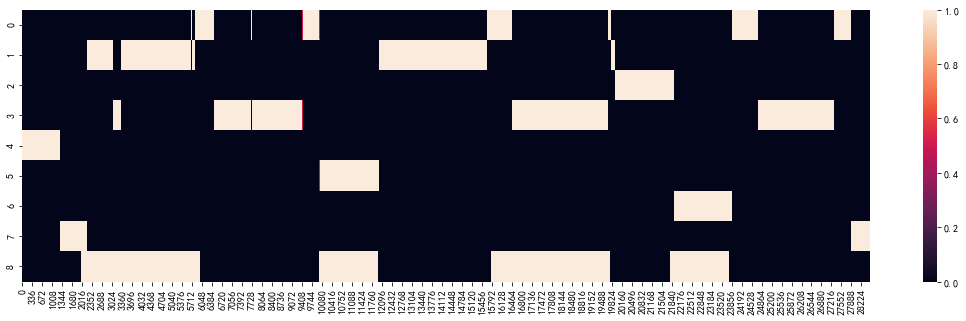

sample_rate:44100, len:6290188
sample_rate:44100, len:6290188
id: 0 stime:    0 etime: 1292 column:3 cut:0
id: 1 stime: 1293 etime: 2199 column:7 cut:0
id: 2 stime: 2200 etime: 3140 column:1 cut:0
id: 3 stime: 3141 etime: 3331 column:5 cut:0
id: 4 stime: 3332 etime: 5835 column:1 cut:0
id: 5 stime: 5836 etime: 6481 column:2 cut:0
id: 6 stime: 6482 etime: 7470 column:5 cut:0
id: 7 stime: 7471 etime: 7806 column:2 cut:0
id: 8 stime: 7807 etime: 7959 column:5 cut:0
id: 9 stime: 7960 etime: 7983 column:2 cut:0
id:10 stime: 7984 etime: 7990 column:5 cut:0
id:11 stime: 7991 etime: 8102 column:2 cut:0
id:12 stime: 8103 etime: 9439 column:5 cut:0
id:13 stime: 9440 etime: 9879 column:2 cut:0
id:14 stime: 9880 etime:10015 column:1 cut:0
id:15 stime:10016 etime:12000 column:4 cut:0
id:16 stime:12001 etime:15688 column:1 cut:0
id:17 stime:15689 etime:15756 column:2 cut:0
id:18 stime:15758 etime:15765 column:1 cut:0
id:19 stime:15766 etime:16576 column:2 cut:0
id:20 stime:16577 etime:19708 column:5

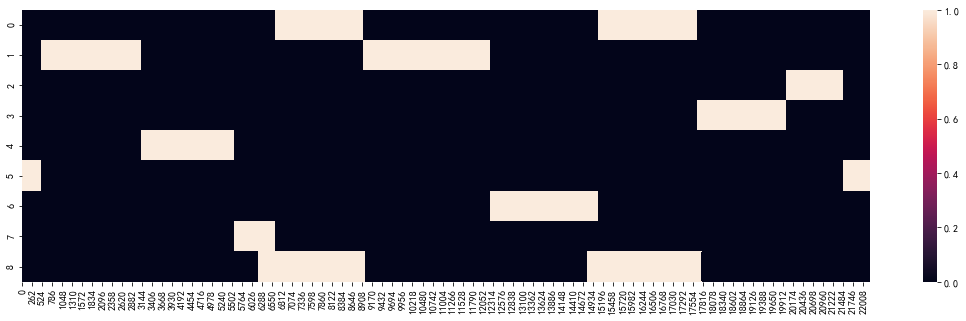

sample_rate:44100, len:4896864
sample_rate:44100, len:4896864
id: 0 stime:    0 etime:  506 column:2 cut:0
id: 1 stime:  507 etime: 3109 column:1 cut:0
id: 2 stime: 3110 etime: 5538 column:4 cut:0
id: 3 stime: 5539 etime: 6660 column:0 cut:0
id: 4 stime: 6661 etime: 8803 column:5 cut:0
id: 5 stime: 8804 etime: 9013 column:0 cut:0
id: 6 stime: 9014 etime:12254 column:1 cut:0
id: 7 stime:12255 etime:15091 column:7 cut:0
id: 8 stime:15092 etime:17675 column:5 cut:0
id: 9 stime:17676 etime:20007 column:6 cut:0
id:10 stime:20008 etime:21495 column:3 cut:0
id:11 stime:21496 etime:22206 column:2 cut:0
MUSIC_ID: 0005
sample_rate:44100, len:9821184
sample_rate:44100, len:9821184
SHAPE: (44539, 8) 44539
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
id: 0 stime:    0 etime: 2208 column:5 cut:1
id: 1 stime: 2209 etime: 3428 column:4 cut:0
id: 2 stime: 3429 etime: 3686 column:7 cut:0
id: 3 

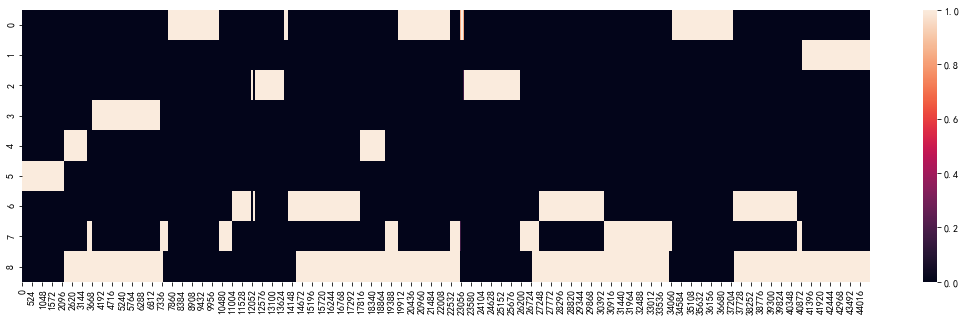

sample_rate:44100, len:9821184
sample_rate:44100, len:9821184
id: 0 stime:    0 etime: 2207 column:4 cut:0
id: 1 stime: 2208 etime: 3432 column:7 cut:0
id: 2 stime: 3433 etime: 3687 column:0 cut:0
id: 3 stime: 3688 etime: 7267 column:5 cut:0
id: 4 stime: 7268 etime: 7666 column:0 cut:0
id: 5 stime: 7667 etime:10319 column:6 cut:0
id: 6 stime:10320 etime:10323 column:0 cut:0
id: 7 stime:10325 etime:10338 column:6 cut:0
id: 8 stime:10339 etime:11031 column:0 cut:0
id: 9 stime:11032 etime:12029 column:1 cut:0
id:10 stime:12030 etime:12162 column:3 cut:0
id:11 stime:12163 etime:12229 column:1 cut:0
id:12 stime:12230 etime:13781 column:3 cut:0
id:13 stime:13782 etime:13987 column:6 cut:0
id:14 stime:13988 etime:17619 column:1 cut:0
id:15 stime:17620 etime:17637 column:0 cut:0
id:16 stime:17641 etime:17735 column:0 cut:0
id:17 stime:17736 etime:17743 column:7 cut:0
id:18 stime:17744 etime:17759 column:1 cut:0
id:19 stime:17760 etime:19058 column:7 cut:0
id:20 stime:19059 etime:19780 column:0

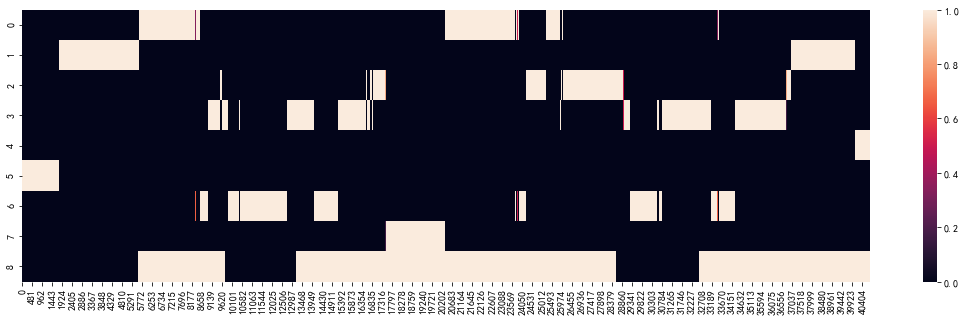

sample_rate:44100, len:8997888
sample_rate:44100, len:8997888
id: 0 stime:    0 etime: 1781 column:3 cut:0
id: 1 stime: 1782 etime: 5622 column:0 cut:0
id: 2 stime: 5623 etime: 8972 column:5 cut:0
id: 3 stime: 8973 etime: 9565 column:4 cut:0
id: 4 stime: 9566 etime: 9600 column:7 cut:0
id: 5 stime: 9601 etime: 9965 column:4 cut:0
id: 6 stime: 9966 etime:10009 column:1 cut:0
id: 7 stime:10010 etime:10065 column:4 cut:0
id: 8 stime:10066 etime:10357 column:1 cut:0
id: 9 stime:10358 etime:10667 column:4 cut:0
id:10 stime:10668 etime:12708 column:1 cut:0
id:11 stime:12709 etime:12915 column:5 cut:0
id:12 stime:12916 etime:14010 column:4 cut:0
id:13 stime:14011 etime:14024 column:1 cut:0
id:14 stime:14025 etime:14040 column:4 cut:0
id:15 stime:14042 etime:15137 column:1 cut:0
id:16 stime:15138 etime:16892 column:4 cut:0
id:17 stime:16893 etime:17329 column:7 cut:0
id:18 stime:17330 etime:20537 column:2 cut:0
id:19 stime:20538 etime:24253 column:5 cut:0
id:20 stime:24254 etime:24259 column:4

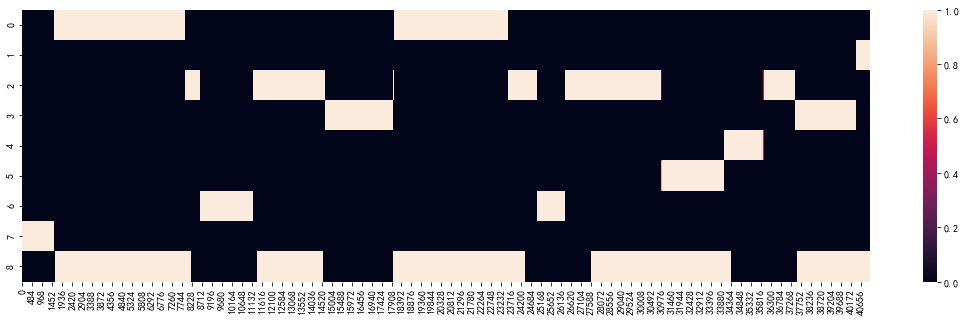

sample_rate:44100, len:9069568
sample_rate:44100, len:9069568
id: 0 stime:    0 etime: 1549 column:3 cut:0
id: 1 stime: 1550 etime: 1557 column:1 cut:0
id: 2 stime: 1558 etime: 1612 column:2 cut:0
id: 3 stime: 1613 etime: 1664 column:1 cut:0
id: 4 stime: 1665 etime: 7921 column:2 cut:0
id: 5 stime: 7922 etime: 8501 column:0 cut:0
id: 6 stime: 8502 etime: 8575 column:1 cut:0
id: 7 stime: 8576 etime: 8646 column:0 cut:0
id: 8 stime: 8647 etime:11240 column:7 cut:0
id: 9 stime:11241 etime:14713 column:0 cut:0
id:10 stime:14714 etime:17938 column:1 cut:0
id:11 stime:17939 etime:17945 column:2 cut:0
id:12 stime:17946 etime:18044 column:0 cut:0
id:13 stime:18045 etime:23512 column:2 cut:0
id:14 stime:23513 etime:25018 column:0 cut:0
id:15 stime:25019 etime:25023 column:7 cut:0
id:16 stime:25027 etime:26320 column:7 cut:0
id:17 stime:26321 etime:30972 column:0 cut:0
id:18 stime:30973 etime:34091 column:4 cut:0
id:19 stime:34092 etime:35971 column:5 cut:0
id:20 stime:35972 etime:37510 column:0

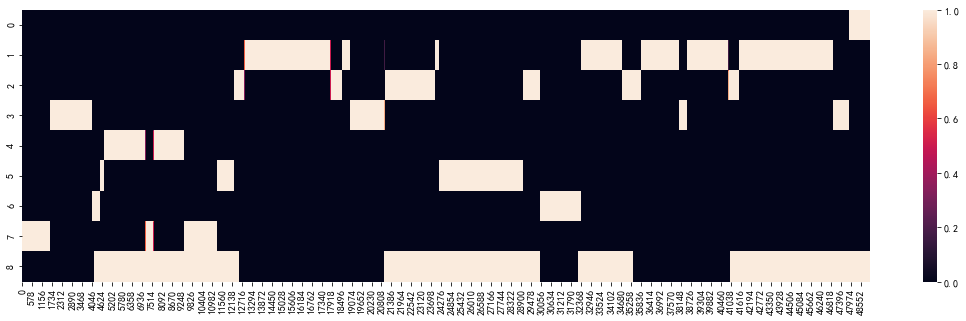

sample_rate:44100, len:10831872
sample_rate:44100, len:10831872
id: 0 stime:    0 etime: 1669 column:4 cut:0
id: 1 stime: 1670 etime: 4157 column:2 cut:0
id: 2 stime: 4158 etime: 4779 column:0 cut:0
id: 3 stime: 4780 etime: 9407 column:3 cut:0
id: 4 stime: 9408 etime: 9942 column:0 cut:0
id: 5 stime: 9943 etime:11249 column:4 cut:0
id: 6 stime:11250 etime:12224 column:6 cut:0
id: 7 stime:12225 etime:12978 column:0 cut:0
id: 8 stime:12979 etime:18282 column:1 cut:0
id: 9 stime:18283 etime:18307 column:0 cut:0
id:10 stime:18308 etime:19012 column:1 cut:0
id:11 stime:19013 etime:20946 column:2 cut:0
id:12 stime:20947 etime:21374 column:0 cut:0
id:13 stime:21375 etime:23746 column:7 cut:0
id:14 stime:23747 etime:24159 column:1 cut:0
id:15 stime:24160 etime:29062 column:6 cut:0
id:16 stime:29063 etime:30628 column:0 cut:0
id:17 stime:30629 etime:32293 column:4 cut:0
id:18 stime:32294 etime:32491 column:0 cut:0
id:19 stime:32492 etime:34726 column:1 cut:0
id:20 stime:34727 etime:34972 column

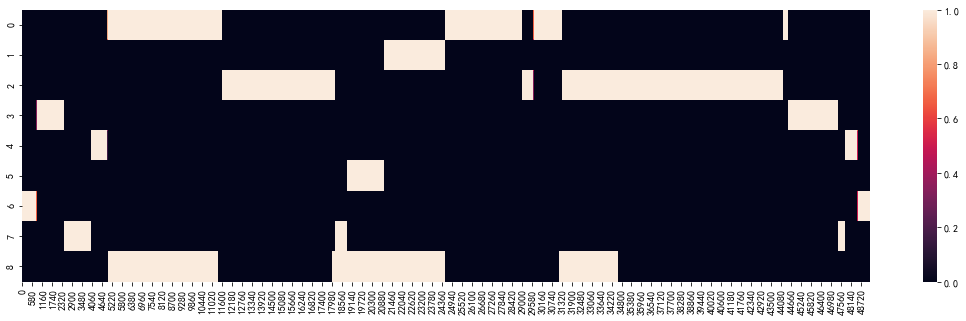

sample_rate:44100, len:10860544
sample_rate:44100, len:10860544
id: 0 stime:    0 etime:  860 column:4 cut:0
id: 1 stime:  861 etime: 2450 column:0 cut:0
id: 2 stime: 2451 etime: 4008 column:5 cut:0
id: 3 stime: 4009 etime: 4981 column:7 cut:0
id: 4 stime: 4982 etime:11609 column:3 cut:0
id: 5 stime:11610 etime:18165 column:2 cut:0
id: 6 stime:18166 etime:18889 column:5 cut:0
id: 7 stime:18890 etime:21056 column:1 cut:0
id: 8 stime:21057 etime:24558 column:6 cut:0
id: 9 stime:24559 etime:29027 column:3 cut:0
id:10 stime:29028 etime:29715 column:2 cut:0
id:11 stime:29717 etime:29718 column:2 cut:0
id:12 stime:29719 etime:31372 column:3 cut:0
id:13 stime:31373 etime:44187 column:2 cut:0
id:14 stime:44188 etime:44476 column:3 cut:0
id:15 stime:44477 etime:47415 column:0 cut:0
id:16 stime:47416 etime:47817 column:5 cut:0
id:17 stime:47818 etime:48533 column:7 cut:0
id:18 stime:48534 etime:49252 column:4 cut:0
MUSIC_ID: 0010
sample_rate:48000, len:10515456
sample_rate:48000, len:10515456
SH

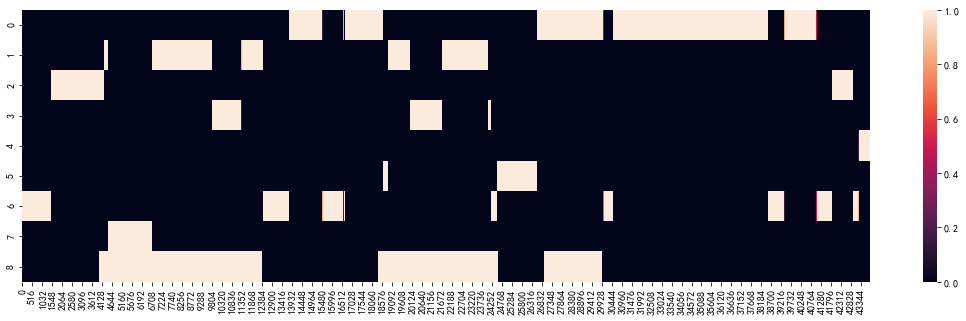

sample_rate:48000, len:10515456
sample_rate:48000, len:10515456
id: 0 stime:    0 etime: 1466 column:7 cut:0
id: 1 stime: 1467 etime: 4236 column:2 cut:0
id: 2 stime: 4237 etime: 4445 column:0 cut:0
id: 3 stime: 4446 etime: 6690 column:5 cut:0
id: 4 stime: 6691 etime: 9838 column:0 cut:0
id: 5 stime: 9839 etime:11283 column:3 cut:0
id: 6 stime:11284 etime:12725 column:0 cut:0
id: 7 stime:12726 etime:18921 column:1 cut:0
id: 8 stime:18922 etime:19142 column:0 cut:0
id: 9 stime:19143 etime:21775 column:3 cut:0
id:10 stime:21776 etime:24028 column:0 cut:0
id:11 stime:24029 etime:24134 column:3 cut:0
id:12 stime:24135 etime:24901 column:7 cut:0
id:13 stime:24902 etime:26627 column:4 cut:0
id:14 stime:26628 etime:41792 column:1 cut:0
id:15 stime:41793 etime:42887 column:2 cut:0
id:16 stime:42888 etime:42949 column:4 cut:0
id:17 stime:42950 etime:43244 column:7 cut:0
id:18 stime:43245 etime:43812 column:6 cut:0
MUSIC_ID: 0011
sample_rate:44100, len:12812288
sample_rate:44100, len:12812288
SH

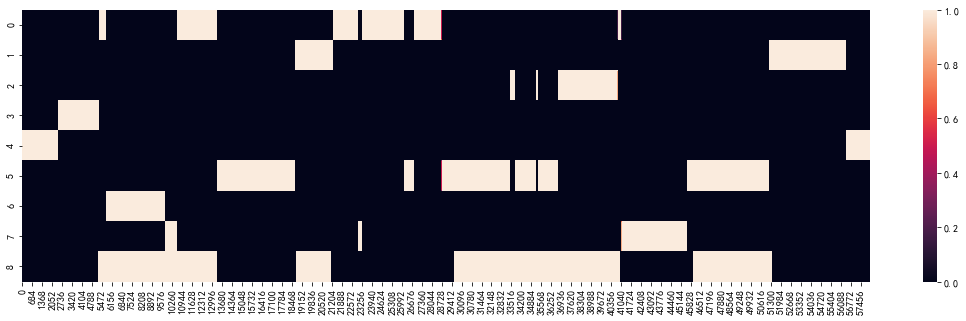

sample_rate:44100, len:12812288
sample_rate:44100, len:12812288
id: 0 stime:    0 etime: 2476 column:2 cut:0
id: 1 stime: 2477 etime: 5294 column:7 cut:0
id: 2 stime: 5295 etime: 5762 column:5 cut:0
id: 3 stime: 5763 etime: 9553 column:4 cut:0
id: 4 stime: 9554 etime: 9849 column:5 cut:0
id: 5 stime: 9850 etime:10629 column:1 cut:0
id: 6 stime:10630 etime:13380 column:5 cut:0
id: 7 stime:13381 etime:18729 column:3 cut:0
id: 8 stime:18730 etime:21335 column:0 cut:0
id: 9 stime:21336 etime:23063 column:5 cut:0
id:10 stime:23064 etime:23335 column:1 cut:0
id:11 stime:23336 etime:26157 column:5 cut:0
id:12 stime:26158 etime:26876 column:3 cut:0
id:13 stime:26877 etime:28749 column:5 cut:0
id:14 stime:28750 etime:33462 column:3 cut:0
id:15 stime:33463 etime:33647 column:6 cut:0
id:16 stime:33648 etime:33665 column:3 cut:0
id:17 stime:33666 etime:33708 column:6 cut:0
id:18 stime:33709 etime:35252 column:3 cut:0
id:19 stime:35253 etime:35345 column:6 cut:0
id:20 stime:35346 etime:36743 column

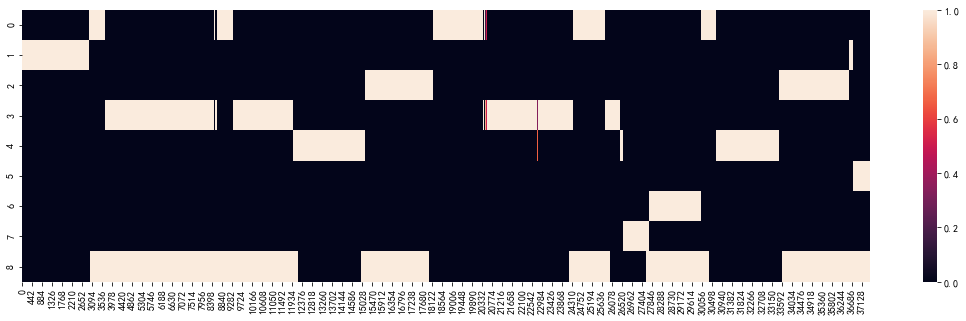

sample_rate:48000, len:8999936
sample_rate:48000, len:8999936
id: 0 stime:    0 etime: 3024 column:2 cut:0
id: 1 stime: 3025 etime: 3208 column:5 cut:0
id: 2 stime: 3209 etime: 3406 column:0 cut:0
id: 3 stime: 3407 etime: 4858 column:7 cut:0
id: 4 stime: 4859 etime: 6878 column:0 cut:0
id: 5 stime: 6879 etime: 7832 column:7 cut:0
id: 6 stime: 7833 etime:11153 column:0 cut:0
id: 7 stime:11154 etime:11182 column:7 cut:0
id: 8 stime:11183 etime:11355 column:0 cut:0
id: 9 stime:11356 etime:11959 column:7 cut:0
id:10 stime:11960 etime:11969 column:0 cut:0
id:11 stime:11970 etime:15179 column:3 cut:0
id:12 stime:15180 etime:18124 column:1 cut:0
id:13 stime:18125 etime:18539 column:0 cut:0
id:14 stime:18540 etime:19809 column:7 cut:0
id:15 stime:19810 etime:20723 column:0 cut:0
id:16 stime:20724 etime:20893 column:7 cut:0
id:17 stime:20894 etime:21869 column:0 cut:0
id:18 stime:21870 etime:22544 column:7 cut:0
id:19 stime:22545 etime:22550 column:0 cut:0
id:20 stime:22551 etime:22554 column:7

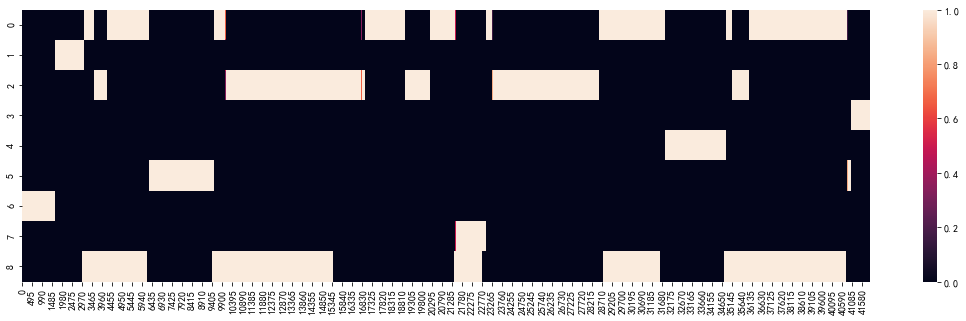

sample_rate:44100, len:9261056
sample_rate:44100, len:9261056
id: 0 stime:    0 etime: 1662 column:1 cut:0
id: 1 stime: 1663 etime: 3084 column:7 cut:0
id: 2 stime: 3085 etime: 3598 column:3 cut:0
id: 3 stime: 3599 etime: 4187 column:0 cut:0
id: 4 stime: 4188 etime: 6314 column:3 cut:0
id: 5 stime: 6315 etime: 9519 column:4 cut:0
id: 6 stime: 9520 etime:10054 column:3 cut:0
id: 7 stime:10055 etime:10074 column:0 cut:0
id: 8 stime:10075 etime:10104 column:3 cut:0
id: 9 stime:10105 etime:16826 column:0 cut:0
id:10 stime:16827 etime:16867 column:3 cut:0
id:11 stime:16868 etime:17006 column:0 cut:0
id:12 stime:17007 etime:18973 column:3 cut:0
id:13 stime:18974 etime:20200 column:0 cut:0
id:14 stime:20201 etime:21476 column:3 cut:0
id:15 stime:21477 etime:22995 column:6 cut:0
id:16 stime:22996 etime:23305 column:3 cut:0
id:17 stime:23306 etime:28589 column:0 cut:0
id:18 stime:28590 etime:31878 column:3 cut:0
id:19 stime:31879 etime:34865 column:2 cut:0
id:20 stime:34866 etime:35182 column:3

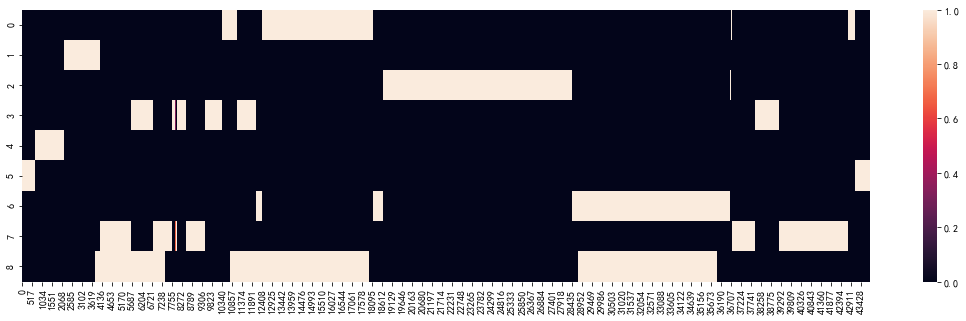

sample_rate:44100, len:9679872
sample_rate:44100, len:9679872
id: 0 stime:    0 etime:  693 column:7 cut:0
id: 1 stime:  694 etime: 2180 column:0 cut:0
id: 2 stime: 2181 etime: 4040 column:4 cut:0
id: 3 stime: 4041 etime: 5674 column:2 cut:0
id: 4 stime: 5675 etime: 6796 column:1 cut:0
id: 5 stime: 6797 etime: 7787 column:2 cut:0
id: 6 stime: 7788 etime: 7958 column:1 cut:0
id: 7 stime: 7959 etime: 8020 column:2 cut:0
id: 8 stime: 8021 etime: 8480 column:1 cut:0
id: 9 stime: 8481 etime: 9477 column:2 cut:0
id:10 stime: 9478 etime:10364 column:1 cut:0
id:11 stime:10365 etime:11153 column:5 cut:0
id:12 stime:11154 etime:12104 column:1 cut:0
id:13 stime:12105 etime:12429 column:6 cut:0
id:14 stime:12430 etime:18180 column:5 cut:0
id:15 stime:18181 etime:18725 column:6 cut:0
id:16 stime:18726 etime:28467 column:3 cut:0
id:17 stime:28468 etime:36684 column:6 cut:0
id:18 stime:36685 etime:36709 column:3 cut:0
id:19 stime:36710 etime:36782 column:5 cut:0
id:20 stime:36783 etime:37970 column:2

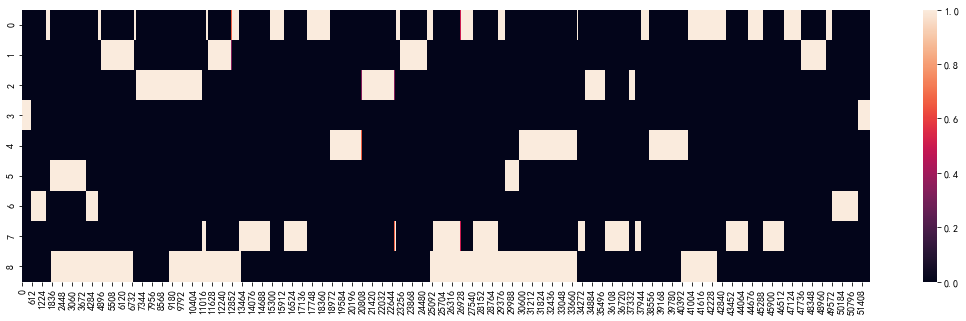

sample_rate:48000, len:12466176
sample_rate:48000, len:12466176
id: 0 stime:    0 etime:  594 column:4 cut:0
id: 1 stime:  595 etime: 1506 column:0 cut:0
id: 2 stime: 1507 etime: 1759 column:2 cut:0
id: 3 stime: 1760 etime: 3919 column:3 cut:0
id: 4 stime: 3920 etime: 4682 column:0 cut:0
id: 5 stime: 4683 etime: 4855 column:2 cut:0
id: 6 stime: 4856 etime: 6835 column:6 cut:0
id: 7 stime: 6836 etime: 6840 column:2 cut:0
id: 8 stime: 6841 etime: 6889 column:6 cut:0
id: 9 stime: 6890 etime: 6936 column:2 cut:0
id:10 stime: 6937 etime: 6949 column:1 cut:0
id:11 stime: 6950 etime: 6961 column:2 cut:0
id:12 stime: 6962 etime:11065 column:7 cut:0
id:13 stime:11066 etime:11273 column:1 cut:0
id:14 stime:11274 etime:11387 column:2 cut:0
id:15 stime:11388 etime:12850 column:6 cut:0
id:16 stime:12851 etime:13085 column:2 cut:0
id:17 stime:13086 etime:13120 column:1 cut:0
id:18 stime:13121 etime:13237 column:2 cut:0
id:19 stime:13238 etime:15233 column:1 cut:0
id:20 stime:15234 etime:16056 column

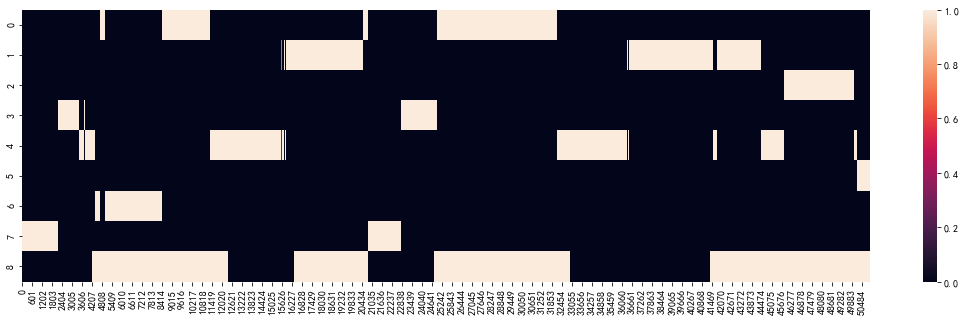

sample_rate:48000, len:12241920
sample_rate:48000, len:12241920
id: 0 stime:    0 etime: 2254 column:5 cut:0
id: 1 stime: 2255 etime: 3990 column:6 cut:0
id: 2 stime: 3991 etime: 4316 column:1 cut:0
id: 3 stime: 4317 etime: 4738 column:7 cut:0
id: 4 stime: 4739 etime: 4996 column:3 cut:0
id: 5 stime: 4997 etime: 8435 column:7 cut:0
id: 6 stime: 8436 etime:11398 column:3 cut:0
id: 7 stime:11399 etime:15585 column:1 cut:0
id: 8 stime:15586 etime:15667 column:0 cut:0
id: 9 stime:15668 etime:15717 column:1 cut:0
id:10 stime:15718 etime:20556 column:0 cut:0
id:11 stime:20557 etime:20599 column:1 cut:0
id:12 stime:20600 etime:20797 column:3 cut:0
id:13 stime:20798 etime:22871 column:5 cut:0
id:14 stime:22872 etime:24948 column:6 cut:0
id:15 stime:24949 etime:32146 column:3 cut:0
id:16 stime:32147 etime:36419 column:1 cut:0
id:17 stime:36420 etime:36457 column:0 cut:0
id:18 stime:36458 etime:36535 column:1 cut:0
id:19 stime:36536 etime:41410 column:0 cut:0
id:20 stime:41411 etime:41814 column

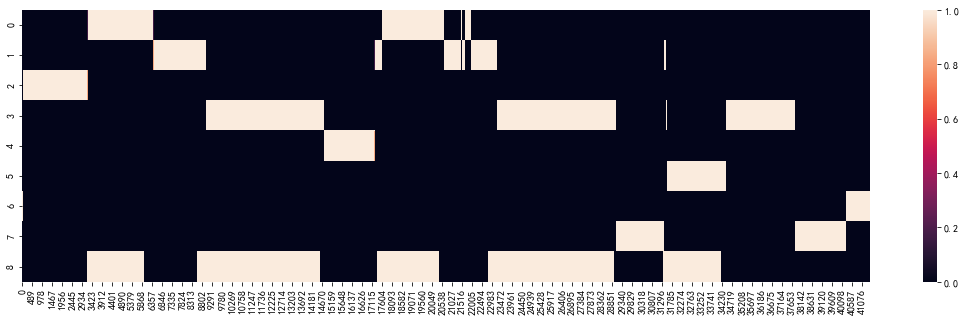

sample_rate:48000, len:9960448
sample_rate:48000, len:9960448
id: 0 stime:    0 etime:   45 column:7 cut:0
id: 1 stime:   46 etime: 3221 column:4 cut:0
id: 2 stime: 3222 etime: 6436 column:1 cut:0
id: 3 stime: 6437 etime: 9033 column:0 cut:0
id: 4 stime: 9034 etime:14762 column:2 cut:0
id: 5 stime:14763 etime:17254 column:6 cut:0
id: 6 stime:17255 etime:17618 column:0 cut:0
id: 7 stime:17619 etime:20648 column:1 cut:0
id: 8 stime:20649 etime:21502 column:0 cut:0
id: 9 stime:21503 etime:21525 column:1 cut:0
id:10 stime:21526 etime:21728 column:0 cut:0
id:11 stime:21729 etime:21975 column:1 cut:0
id:12 stime:21976 etime:23259 column:0 cut:0
id:13 stime:23260 etime:29085 column:2 cut:0
id:14 stime:29086 etime:31433 column:3 cut:0
id:15 stime:31434 etime:31557 column:0 cut:0
id:16 stime:31558 etime:31571 column:2 cut:0
id:17 stime:31572 etime:34485 column:5 cut:0
id:18 stime:34486 etime:37848 column:2 cut:0
id:19 stime:37849 etime:40319 column:3 cut:0
id:20 stime:40320 etime:41500 column:7

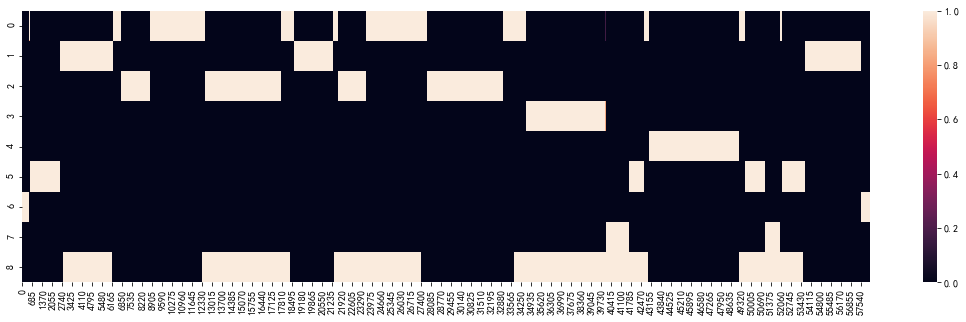

sample_rate:48000, len:13970432
sample_rate:48000, len:13970432
id: 0 stime:    0 etime:  527 column:6 cut:0
id: 1 stime:  528 etime:  637 column:4 cut:0
id: 2 stime:  638 etime: 2550 column:2 cut:0
id: 3 stime: 2551 etime: 6255 column:1 cut:0
id: 4 stime: 6256 etime: 6824 column:4 cut:0
id: 5 stime: 6825 etime: 8803 column:0 cut:0
id: 6 stime: 8804 etime:12592 column:4 cut:0
id: 7 stime:12593 etime:17763 column:0 cut:0
id: 8 stime:17764 etime:18717 column:4 cut:0
id: 9 stime:18718 etime:21364 column:1 cut:0
id:10 stime:21365 etime:21734 column:4 cut:0
id:11 stime:21735 etime:23652 column:0 cut:0
id:12 stime:23653 etime:27814 column:4 cut:0
id:13 stime:27815 etime:33037 column:0 cut:0
id:14 stime:33038 etime:34557 column:4 cut:0
id:15 stime:34558 etime:39975 column:5 cut:0
id:16 stime:39976 etime:40080 column:4 cut:0
id:17 stime:40081 etime:41617 column:7 cut:0
id:18 stime:41618 etime:42749 column:2 cut:0
id:19 stime:42750 etime:43071 column:4 cut:0
id:20 stime:43072 etime:48454 column

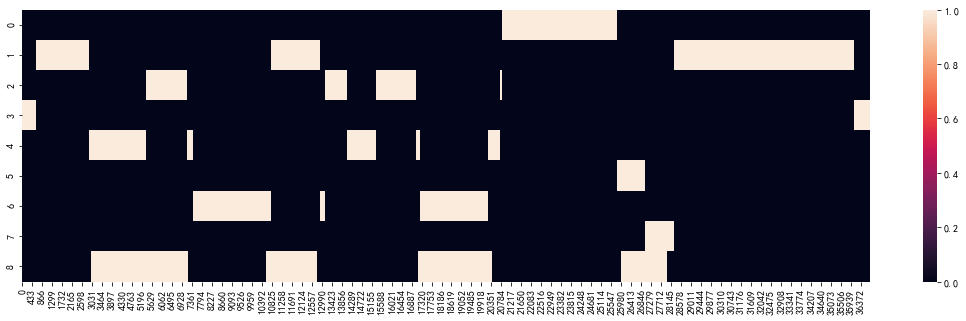

sample_rate:44100, len:8112128
sample_rate:44100, len:8112128
id: 0 stime:    0 etime:  633 column:6 cut:0
id: 1 stime:  634 etime: 2942 column:0 cut:0
id: 2 stime: 2943 etime: 5399 column:7 cut:0
id: 3 stime: 5400 etime: 7160 column:2 cut:0
id: 4 stime: 7161 etime: 7420 column:7 cut:0
id: 5 stime: 7421 etime:10848 column:4 cut:0
id: 6 stime:10849 etime:12882 column:0 cut:0
id: 7 stime:12883 etime:12891 column:4 cut:0
id: 8 stime:12892 etime:12932 column:0 cut:0
id: 9 stime:12933 etime:13157 column:4 cut:0
id:10 stime:13158 etime:14111 column:2 cut:0
id:11 stime:14112 etime:15381 column:7 cut:0
id:12 stime:15382 etime:17126 column:2 cut:0
id:13 stime:17127 etime:17284 column:7 cut:0
id:14 stime:17285 etime:20194 column:4 cut:0
id:15 stime:20195 etime:20762 column:7 cut:0
id:16 stime:20763 etime:20829 column:2 cut:0
id:17 stime:20830 etime:25810 column:1 cut:0
id:18 stime:25811 etime:27045 column:3 cut:0
id:19 stime:27046 etime:28305 column:5 cut:0
id:20 stime:28306 etime:36098 column:0

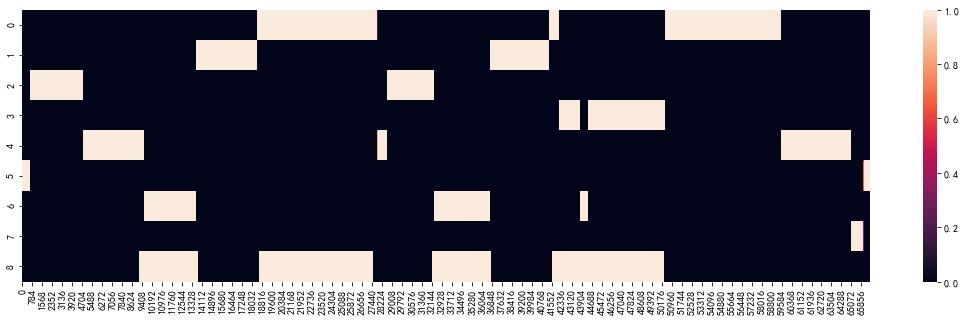

sample_rate:44100, len:14675968
sample_rate:44100, len:14675968
id: 0 stime:    0 etime:  640 column:6 cut:0
id: 1 stime:  641 etime: 4778 column:0 cut:0
id: 2 stime: 4779 etime: 9564 column:1 cut:0
id: 3 stime: 9565 etime:13695 column:3 cut:0
id: 4 stime:13696 etime:18468 column:5 cut:0
id: 5 stime:18469 etime:27910 column:2 cut:0
id: 6 stime:27911 etime:28642 column:1 cut:0
id: 7 stime:28643 etime:32392 column:0 cut:0
id: 8 stime:32393 etime:36771 column:3 cut:0
id: 9 stime:36772 etime:41368 column:5 cut:0
id:10 stime:41369 etime:42132 column:2 cut:0
id:11 stime:42133 etime:43817 column:4 cut:0
id:12 stime:43818 etime:44424 column:3 cut:0
id:13 stime:44425 etime:50476 column:4 cut:0
id:14 stime:50477 etime:59573 column:2 cut:0
id:15 stime:59574 etime:65045 column:1 cut:0
id:16 stime:65046 etime:66054 column:7 cut:0
id:17 stime:66055 etime:66556 column:6 cut:0
MUSIC_ID: 0021
sample_rate:48000, len:10848256
sample_rate:48000, len:10848256
SHAPE: (45199, 8) 45198
SHAPE: (45198, 8) 45198

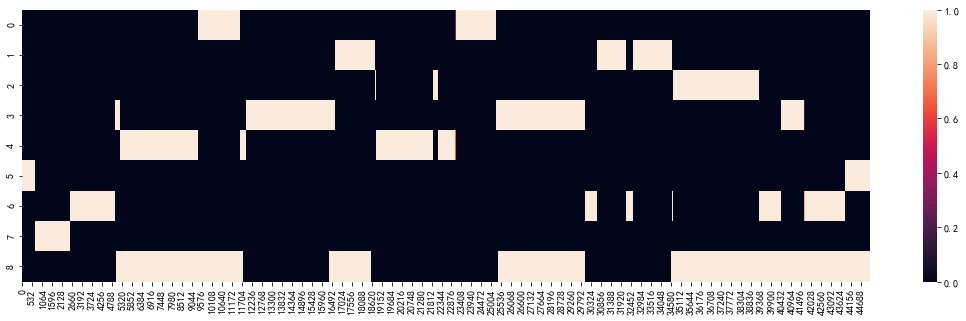

sample_rate:48000, len:10848256
sample_rate:48000, len:10848256
id: 0 stime:    0 etime: 2401 column:3 cut:0
id: 1 stime: 2402 etime: 5008 column:1 cut:0
id: 2 stime: 5009 etime: 5215 column:2 cut:0
id: 3 stime: 5216 etime: 9408 column:0 cut:0
id: 4 stime: 9409 etime:11631 column:6 cut:0
id: 5 stime:11632 etime:11964 column:0 cut:0
id: 6 stime:11965 etime:16642 column:2 cut:0
id: 7 stime:16643 etime:17045 column:1 cut:0
id: 8 stime:17046 etime:17155 column:5 cut:0
id: 9 stime:17156 etime:17854 column:1 cut:0
id:10 stime:17855 etime:18712 column:5 cut:0
id:11 stime:18713 etime:19059 column:7 cut:0
id:12 stime:19060 etime:19071 column:0 cut:0
id:13 stime:19072 etime:19147 column:7 cut:0
id:14 stime:19148 etime:21864 column:0 cut:0
id:15 stime:21865 etime:22244 column:7 cut:0
id:16 stime:22245 etime:23117 column:0 cut:0
id:17 stime:23118 etime:25269 column:6 cut:0
id:18 stime:25270 etime:30049 column:2 cut:0
id:19 stime:30050 etime:30723 column:1 cut:0
id:20 stime:30724 etime:32057 column

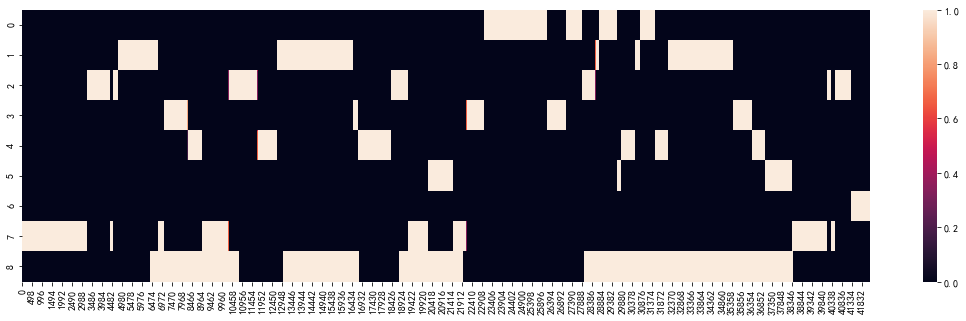

sample_rate:48000, len:10139648
sample_rate:48000, len:10139648
id: 0 stime:    0 etime:  439 column:7 cut:0
id: 1 stime:  440 etime: 1401 column:0 cut:0
id: 2 stime: 1402 etime: 4225 column:7 cut:0
id: 3 stime: 4226 etime: 4232 column:5 cut:0
id: 4 stime: 4233 etime: 4816 column:7 cut:0
id: 5 stime: 4817 etime: 6773 column:2 cut:0
id: 6 stime: 6774 etime: 7096 column:3 cut:0
id: 7 stime: 7097 etime: 8253 column:1 cut:0
id: 8 stime: 8254 etime: 9004 column:5 cut:0
id: 9 stime: 9005 etime: 9040 column:7 cut:0
id:10 stime: 9041 etime:10201 column:3 cut:0
id:11 stime:10202 etime:10539 column:7 cut:0
id:12 stime:10540 etime:11765 column:6 cut:0
id:13 stime:11766 etime:12686 column:5 cut:0
id:14 stime:12687 etime:16486 column:2 cut:0
id:15 stime:16487 etime:16689 column:1 cut:0
id:16 stime:16693 etime:16750 column:1 cut:0
id:17 stime:16751 etime:18507 column:5 cut:0
id:18 stime:18508 etime:19843 column:7 cut:0
id:19 stime:19844 etime:21914 column:0 cut:0
id:20 stime:21915 etime:22132 column

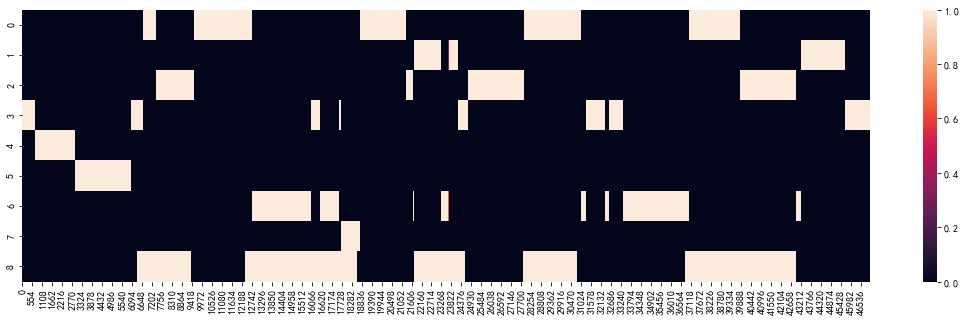

sample_rate:48000, len:11297792
sample_rate:48000, len:11297792
id: 0 stime:    0 etime:  788 column:7 cut:0
id: 1 stime:  789 etime: 2958 column:4 cut:0
id: 2 stime: 2959 etime: 5835 column:5 cut:0
id: 3 stime: 5836 etime: 6659 column:7 cut:0
id: 4 stime: 6660 etime: 6687 column:2 cut:0
id: 5 stime: 6688 etime: 7405 column:1 cut:0
id: 6 stime: 7406 etime: 9511 column:3 cut:0
id: 7 stime: 9512 etime:12758 column:1 cut:0
id: 8 stime:12759 etime:13342 column:2 cut:0
id: 9 stime:13343 etime:14322 column:0 cut:0
id:10 stime:14323 etime:14640 column:2 cut:0
id:11 stime:14641 etime:15617 column:0 cut:0
id:12 stime:15618 etime:18722 column:2 cut:0
id:13 stime:18723 etime:21580 column:1 cut:0
id:14 stime:21581 etime:21586 column:3 cut:0
id:15 stime:21587 etime:21592 column:1 cut:0
id:16 stime:21593 etime:21632 column:3 cut:0
id:17 stime:21633 etime:21857 column:2 cut:0
id:18 stime:21858 etime:22775 column:6 cut:0
id:19 stime:22776 etime:24405 column:0 cut:0
id:20 stime:24406 etime:24686 column

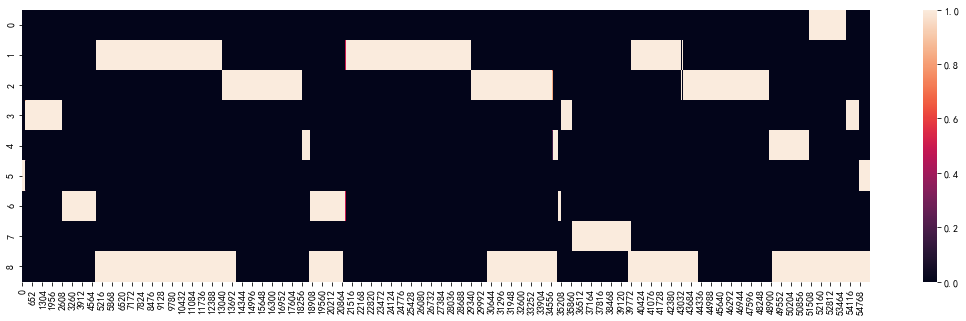

sample_rate:48000, len:13300736
sample_rate:48000, len:13300736
id: 0 stime:    0 etime:  231 column:6 cut:0
id: 1 stime:  232 etime: 2638 column:3 cut:0
id: 2 stime: 2639 etime: 4795 column:7 cut:0
id: 3 stime: 4796 etime: 5200 column:1 cut:0
id: 4 stime: 5201 etime: 6288 column:5 cut:0
id: 5 stime: 6289 etime:12983 column:1 cut:0
id: 6 stime:12984 etime:18487 column:0 cut:0
id: 7 stime:18488 etime:18497 column:7 cut:0
id: 8 stime:18498 etime:18506 column:0 cut:0
id: 9 stime:18507 etime:21047 column:7 cut:0
id:10 stime:21048 etime:21441 column:1 cut:0
id:11 stime:21442 etime:22500 column:5 cut:0
id:12 stime:22501 etime:29282 column:1 cut:0
id:13 stime:29283 etime:29313 column:0 cut:0
id:14 stime:29314 etime:29331 column:1 cut:0
id:15 stime:29332 etime:34807 column:0 cut:0
id:16 stime:34808 etime:35236 column:7 cut:0
id:17 stime:35237 etime:35955 column:3 cut:0
id:18 stime:35956 etime:39816 column:2 cut:0
id:19 stime:39817 etime:43226 column:1 cut:0
id:20 stime:43227 etime:48874 column

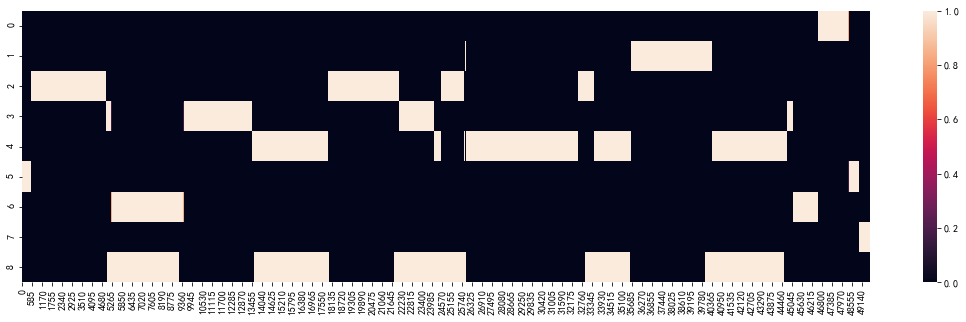

sample_rate:48000, len:11916288
sample_rate:48000, len:11916288
id: 0 stime:    0 etime:  570 column:2 cut:0
id: 1 stime:  571 etime: 4948 column:3 cut:0
id: 2 stime: 4949 etime: 5253 column:5 cut:0
id: 3 stime: 5254 etime: 9472 column:1 cut:0
id: 4 stime: 9473 etime:13481 column:5 cut:0
id: 5 stime:13482 etime:17955 column:0 cut:0
id: 6 stime:17956 etime:22103 column:3 cut:0
id: 7 stime:22104 etime:24066 column:5 cut:0
id: 8 stime:24067 etime:24098 column:0 cut:0
id: 9 stime:24099 etime:24143 column:5 cut:0
id:10 stime:24144 etime:24563 column:0 cut:0
id:11 stime:24564 etime:24577 column:3 cut:0
id:12 stime:24578 etime:24590 column:0 cut:0
id:13 stime:24591 etime:25873 column:3 cut:0
id:14 stime:25874 etime:25939 column:0 cut:0
id:15 stime:25940 etime:25980 column:6 cut:0
id:16 stime:25981 etime:32583 column:0 cut:0
id:17 stime:32584 etime:33477 column:3 cut:0
id:18 stime:33478 etime:35660 column:0 cut:0
id:19 stime:35661 etime:40386 column:6 cut:0
id:20 stime:40387 etime:44775 column

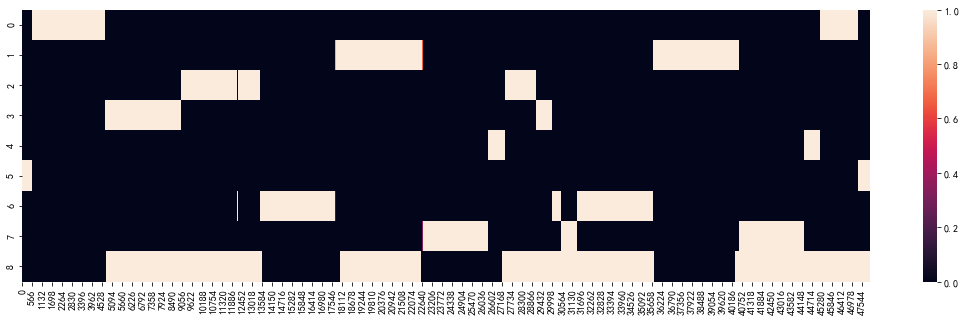

sample_rate:48000, len:11528192
sample_rate:48000, len:11528192
id: 0 stime:    0 etime:  564 column:6 cut:0
id: 1 stime:  565 etime: 4709 column:3 cut:0
id: 2 stime: 4710 etime: 9000 column:7 cut:0
id: 3 stime: 9001 etime:13478 column:5 cut:0
id: 4 stime:13479 etime:17760 column:0 cut:0
id: 5 stime:17761 etime:22675 column:2 cut:0
id: 6 stime:22676 etime:26361 column:4 cut:0
id: 7 stime:26362 etime:27363 column:1 cut:0
id: 8 stime:27364 etime:30324 column:5 cut:0
id: 9 stime:30325 etime:30536 column:0 cut:0
id:10 stime:30537 etime:31438 column:4 cut:0
id:11 stime:31439 etime:35754 column:0 cut:0
id:12 stime:35755 etime:40527 column:2 cut:0
id:13 stime:40528 etime:44292 column:4 cut:0
id:14 stime:44293 etime:45185 column:1 cut:0
id:15 stime:45186 etime:47353 column:3 cut:0
id:16 stime:47354 etime:48032 column:6 cut:0
MUSIC_ID: 0027
sample_rate:48000, len:10823476
sample_rate:48000, len:10823476
SHAPE: (45096, 8) 45095
SHAPE: (45095, 8) 45095
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

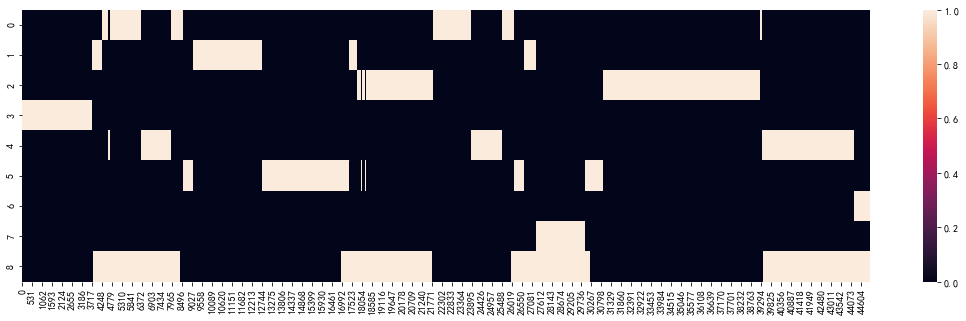

sample_rate:48000, len:10823476
sample_rate:48000, len:10823476
id: 0 stime:    0 etime: 3726 column:6 cut:0
id: 1 stime: 3727 etime: 4102 column:5 cut:0
id: 2 stime: 4103 etime: 4312 column:7 cut:0
id: 3 stime: 4313 etime: 6289 column:0 cut:0
id: 4 stime: 6290 etime: 8198 column:1 cut:0
id: 5 stime: 8199 etime: 8612 column:0 cut:0
id: 6 stime: 8613 etime:12737 column:5 cut:0
id: 7 stime:12738 etime:17162 column:3 cut:0
id: 8 stime:17163 etime:17806 column:5 cut:0
id: 9 stime:17807 etime:18417 column:3 cut:0
id:10 stime:18418 etime:18618 column:7 cut:0
id:11 stime:18619 etime:18634 column:3 cut:0
id:12 stime:18635 etime:18783 column:7 cut:0
id:13 stime:18784 etime:18850 column:2 cut:0
id:14 stime:18851 etime:18855 column:7 cut:0
id:15 stime:18856 etime:18868 column:2 cut:0
id:16 stime:18869 etime:21900 column:7 cut:0
id:17 stime:21901 etime:23608 column:0 cut:0
id:18 stime:23609 etime:23664 column:1 cut:0
id:19 stime:23665 etime:23868 column:0 cut:0
id:20 stime:23869 etime:25803 column

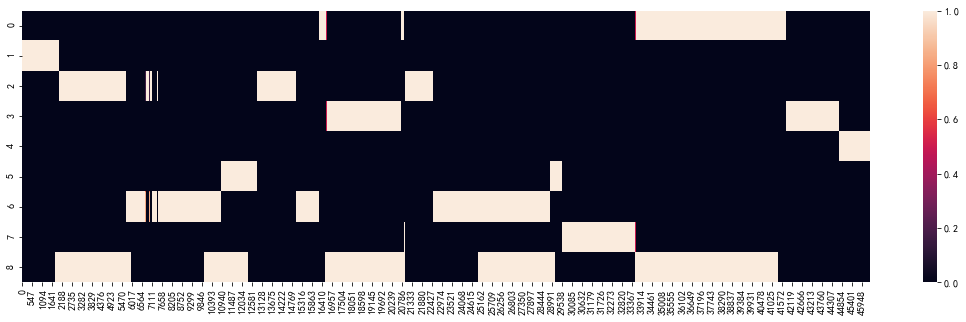

sample_rate:48000, len:11144208
sample_rate:48000, len:11144208
id: 0 stime:    0 etime: 2023 column:6 cut:0
id: 1 stime: 2024 etime: 5707 column:1 cut:0
id: 2 stime: 5708 etime: 6737 column:2 cut:0
id: 3 stime: 6738 etime: 6754 column:1 cut:0
id: 4 stime: 6755 etime: 6793 column:2 cut:0
id: 5 stime: 6794 etime: 6990 column:1 cut:0
id: 6 stime: 6991 etime: 7034 column:2 cut:0
id: 7 stime: 7035 etime: 7140 column:1 cut:0
id: 8 stime: 7141 etime: 7144 column:2 cut:0
id: 9 stime: 7145 etime: 7151 column:1 cut:0
id:10 stime: 7152 etime: 7437 column:2 cut:0
id:11 stime: 7438 etime: 7443 column:1 cut:0
id:12 stime: 7444 etime: 7451 column:2 cut:0
id:13 stime: 7452 etime: 7454 column:1 cut:0
id:14 stime: 7455 etime: 7461 column:2 cut:0
id:15 stime: 7462 etime: 7466 column:1 cut:0
id:16 stime: 7467 etime:10912 column:2 cut:0
id:17 stime:10913 etime:12864 column:7 cut:0
id:18 stime:12865 etime:14825 column:1 cut:0
id:19 stime:14826 etime:14979 column:2 cut:0
id:20 stime:14980 etime:15003 column

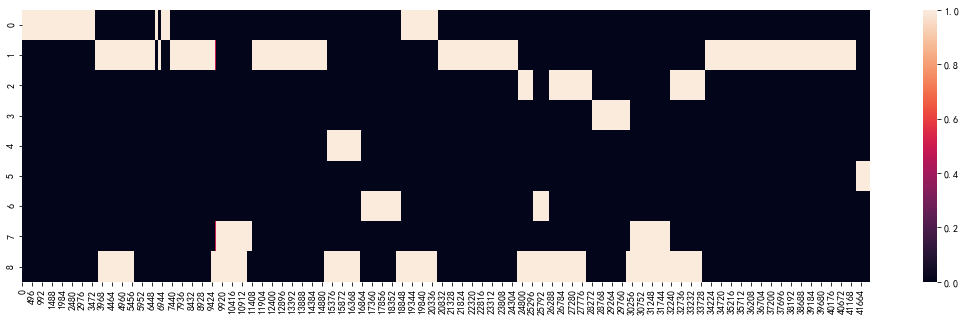

sample_rate:48000, len:10108039
sample_rate:48000, len:10108039
id: 0 stime:    0 etime: 3644 column:3 cut:0
id: 1 stime: 3645 etime: 6645 column:7 cut:0
id: 2 stime: 6646 etime: 6781 column:3 cut:0
id: 3 stime: 6782 etime: 6918 column:7 cut:0
id: 4 stime: 6919 etime: 7383 column:3 cut:0
id: 5 stime: 7384 etime: 9012 column:7 cut:0
id: 6 stime: 9013 etime: 9357 column:2 cut:0
id: 7 stime: 9358 etime: 9373 column:7 cut:0
id: 8 stime: 9377 etime: 9627 column:7 cut:0
id: 9 stime: 9628 etime:11420 column:5 cut:0
id:10 stime:11421 etime:15193 column:7 cut:0
id:11 stime:15194 etime:16867 column:0 cut:0
id:12 stime:16868 etime:18840 column:4 cut:0
id:13 stime:18841 etime:20644 column:3 cut:0
id:14 stime:20645 etime:24522 column:7 cut:0
id:15 stime:24523 etime:25357 column:2 cut:0
id:16 stime:25358 etime:26225 column:4 cut:0
id:17 stime:26226 etime:28312 column:2 cut:0
id:18 stime:28313 etime:30208 column:6 cut:0
id:19 stime:30209 etime:32168 column:5 cut:0
id:20 stime:32169 etime:32345 column

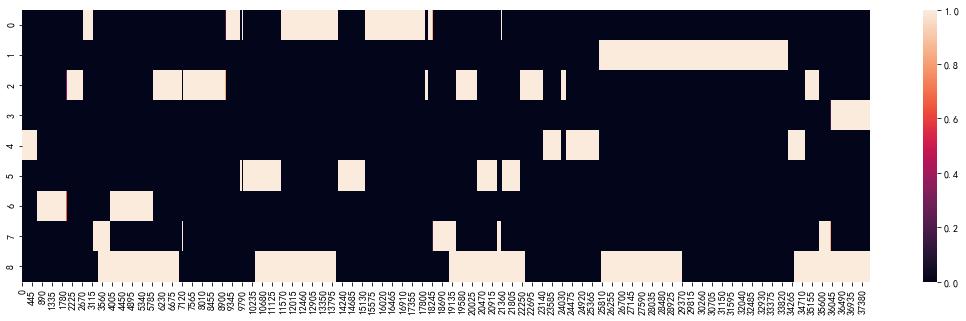

sample_rate:44100, len:8325352
sample_rate:44100, len:8325352
id: 0 stime:    0 etime:  705 column:7 cut:0
id: 1 stime:  706 etime: 1989 column:0 cut:0
id: 2 stime: 1990 etime: 2706 column:3 cut:0
id: 3 stime: 2707 etime: 3157 column:4 cut:0
id: 4 stime: 3158 etime: 3941 column:2 cut:0
id: 5 stime: 3942 etime: 5852 column:0 cut:0
id: 6 stime: 5853 etime: 7155 column:3 cut:0
id: 7 stime: 7156 etime: 7171 column:2 cut:0
id: 8 stime: 7172 etime: 9065 column:3 cut:0
id: 9 stime: 9066 etime: 9731 column:4 cut:0
id:10 stime: 9732 etime: 9824 column:6 cut:0
id:11 stime: 9825 etime: 9852 column:4 cut:0
id:12 stime: 9853 etime:11532 column:6 cut:0
id:13 stime:11533 etime:14075 column:4 cut:0
id:14 stime:14076 etime:15276 column:6 cut:0
id:15 stime:15277 etime:17932 column:4 cut:0
id:16 stime:17933 etime:18082 column:3 cut:0
id:17 stime:18083 etime:18279 column:4 cut:0
id:18 stime:18280 etime:19344 column:2 cut:0
id:19 stime:19345 etime:20283 column:3 cut:0
id:20 stime:20284 etime:21167 column:6

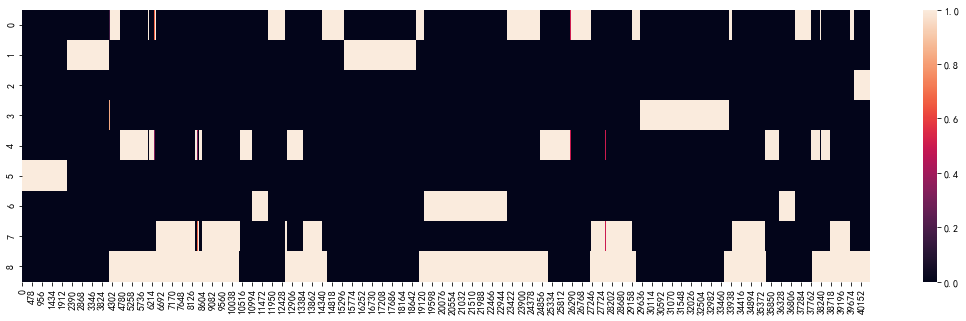

sample_rate:48000, len:9741312
sample_rate:48000, len:9741312
id: 0 stime:    0 etime: 2165 column:1 cut:0
id: 1 stime: 2166 etime: 4186 column:2 cut:0
id: 2 stime: 4187 etime: 4714 column:0 cut:0
id: 3 stime: 4715 etime: 6370 column:7 cut:0
id: 4 stime: 6371 etime: 6430 column:0 cut:0
id: 5 stime: 6431 etime: 8506 column:5 cut:0
id: 6 stime: 8507 etime: 8612 column:7 cut:0
id: 7 stime: 8613 etime:10441 column:5 cut:0
id: 8 stime:10442 etime:11041 column:7 cut:0
id: 9 stime:11042 etime:11810 column:3 cut:0
id:10 stime:11811 etime:12608 column:0 cut:0
id:11 stime:12609 etime:12717 column:5 cut:0
id:12 stime:12718 etime:13464 column:7 cut:0
id:13 stime:13465 etime:14319 column:5 cut:0
id:14 stime:14320 etime:15435 column:0 cut:0
id:15 stime:15436 etime:18863 column:2 cut:0
id:16 stime:18864 etime:19244 column:0 cut:0
id:17 stime:19245 etime:23205 column:3 cut:0
id:18 stime:23206 etime:24217 column:0 cut:0
id:19 stime:24218 etime:24352 column:3 cut:0
id:20 stime:24353 etime:24370 column:0

In [14]:
N = 31
for i in range(3, N + 1):
    name = "%04d" % i
    manFileName = "./Data/MAN/%s.man" % name
    wavFileName = "./Data/WAV/%s.wav" % name

    import os
    if os.path.exists(manFileName):
        ShowMapForWav(wavFileName, manFileName)

    # 无论如何都会制作这个
    SaveDataIntoJson(wavFileName)
